In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 83.0 MB/s eta 0:00:00


In [2]:
import cv2  # For image processing
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For displaying images
import pandas as pd
import geopandas as gpd
import os
import shutil
import glob
import pickle

import rasterio
from rasterio.plot import reshape_as_image
from rasterio.features import rasterize

from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union
from concurrent.futures import ProcessPoolExecutor, as_completed


%matplotlib inline

In [3]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d isaienkov/deforestation-in-ukraine

!mkdir deforestation-in-ukraine
!unzip deforestation-in-ukraine.zip -d deforestation-in-ukraine

!rm deforestation-in-ukraine.zip


Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: deforestation-in-ukraine/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE/GRANULE/L1C_T36UYA_A003350_20160212T084510/QI_DATA/MSK_NODATA_B11.gml  
  inflating: deforestation-in-ukraine/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE/GRANULE/L1C_T36UYA_A003350_20160212T084510/QI_DATA/MSK_NODATA_B12.gml  
  inflating: deforestation-in-ukraine/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE/GRANULE/L1C_T36UYA_A003350_20160212T084510/QI_DATA/MSK_NODATA_B8A.gml  
  inflating: deforestation-in-ukraine/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE/GRANULE/L1C_T36UYA_A003350_20160212T084510/QI_DATA/MSK_S

In [4]:
base_dataset_path = 'deforestation-in-ukraine/'
development_dataset_path = 'smaller_dev_dataset/'
df = gpd.read_file('deforestation-in-ukraine/deforestation_labels.geojson')

In [5]:
print(df['geometry'][0])

POLYGON ((35.79130110364752 50.174056041526406, 35.79277364075651 50.17353744707388, 35.79297457903032 50.17264504733532, 35.791157474146246 50.17247166166292, 35.7903885750503 50.17287983873138, 35.79130110364752 50.174056041526406))


In [16]:

def preprocess_and_save_images(base_dataset_path, dev_dataset_path, max_dimension=1024):
    if not os.path.exists(dev_dataset_path):
        os.makedirs(dev_dataset_path)

    for folder in os.listdir(base_dataset_path):
        # Construct the path to the IMG_DATA folder where TCI images are stored
        img_data_path = os.path.join(base_dataset_path, folder, "*.SAFE/GRANULE/*/IMG_DATA/*_TCI.jp2")

        # Find the TCI image file
        tci_image_file = glob.glob(img_data_path)

        for image_file in tci_image_file:

            subdirectory_name = image_file.split('/')[-3]
            dest_subdirectory_path = os.path.join(dev_dataset_path, subdirectory_name)

            if not os.path.exists(dest_subdirectory_path):
                os.makedirs(dest_subdirectory_path)

            # Preprocess the image
            preprocessed_image = load_and_preprocess_image(image_file, max_dimension)

            # Construct the path for saving the preprocessed image
            dest_image_path = os.path.join(dest_subdirectory_path, os.path.basename(image_file).replace('.jp2', '.jpg'))
            # Save the preprocessed image
            cv2.imwrite(dest_image_path, preprocessed_image, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

def load_and_preprocess_image(image_path, max_dimension=1024):
    img = cv2.imread(image_path, 0)  # 0 for grayscale
    height, width = img.shape
    scale = max_dimension / max(height, width)
    resized_img = cv2.resize(img, (int(width * scale), int(height * scale)))
    return resized_img

preprocess_and_save_images(base_dataset_path, development_dataset_path)

In [11]:
# # For deleting smaller database

# # Check if the directory exists
# if os.path.exists(development_dataset_path):
#     try:
#         # Use shutil.rmtree to remove the directory and its contents recursively
#         shutil.rmtree(development_dataset_path)
#         print(f"Directory at '{development_dataset_path}' and its contents deleted successfully.")
#     except Exception as e:
#         # Handle any errors that may occur during deletion
#         print(f"Error deleting directory at '{development_dataset_path}': {e}")
# else:
#     print(f"Directory at '{development_dataset_path}' does not exist.")

Directory at 'smaller_dev_dataset/' and its contents deleted successfully.


In [17]:
# One of option to compare image feature was to crop it to polygon and compare them
def crop_image_to_polygon(image_path, polygon):
    with rasterio.open(image_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, [polygon], crop=True)
        out_meta = src.meta
    out_meta.update({"driver": "JPEG",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    return out_image, out_meta

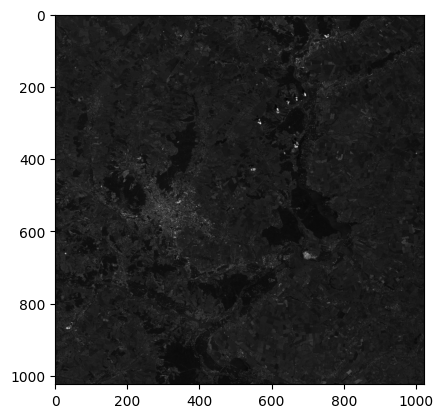

In [18]:
# Debugging load_and_preprocess_image functions
image = load_and_preprocess_image('deforestation-in-ukraine/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426.SAFE/GRANULE/L1C_T36UYA_A011816_20190611T084501/IMG_DATA/T36UYA_20190611T083609_TCI.jp2')
plt.imshow(image, cmap='gray')
plt.show()

In [19]:
def extract_and_save_features(base_directory, sift):
    # Iterate through all folders in the base directory
    for folder_name in os.listdir(base_directory):
        folder_path = os.path.join(base_directory, folder_name)

        if os.path.isdir(folder_path):
            # Process only the TCI images in each folder
            for image_file in glob.glob(os.path.join(folder_path, '*_TCI.jpg')):
                # Extract features
                img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
                keypoints, descriptors = sift.detectAndCompute(img, None)

                # Convert keypoints to a serializable format
                keypoints_serializable = [(kp.pt, kp.size, kp.angle, kp.response, kp.octave, kp.class_id) for kp in keypoints]

                # Save keypoints and descriptors in the same folder
                keypoints_file = os.path.join(folder_path, 'keypoints.pkl')
                descriptors_file = os.path.join(folder_path, 'features.pkl')

                with open(keypoints_file, 'wb') as kp_file:
                    pickle.dump(keypoints_serializable, kp_file)
                with open(descriptors_file, 'wb') as des_file:
                    pickle.dump(descriptors, des_file)


# Initialize SIFT
sift = cv2.SIFT_create()


In [20]:
extract_and_save_features(development_dataset_path, sift)

In [21]:
def load_features(directory):
    image_features = {}

    # Iterate through all subdirectories in the directory
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            # Load descriptors from each folder
            descriptor_file = os.path.join(folder_path, 'features.pkl')
            if os.path.exists(descriptor_file):
                with open(descriptor_file, 'rb') as f:
                    descriptors = pickle.load(f)
                # The image file name is derived from the folder name
                image_file = glob.glob(os.path.join(folder_path, '*.jpg'))[0]
                image_features[image_file] = descriptors
    return image_features

In [22]:
def compare_and_record_matches(args):
    img_path1, img_path2, des1, des2, threshold = args
    num_matches = compare_features(des1, des2, threshold)
    if num_matches > match_threshold:
        return (img_path1, img_path2)
    return None

In [24]:
compare_args = []
image_features = load_features(development_dataset_path)
image_paths = list(image_features.keys())
for i, img_path1 in enumerate(image_paths):
    for img_path2 in image_paths[i+1:]:
        compare_args.append((img_path1, img_path2, image_features[img_path1], image_features[img_path2], 0.75))


#threshold=0.75 will filter good matches between images
def compare_features(des1, des2, threshold=0.75):
    bf = cv2.BFMatcher() # Initialize Brute-Force Matcher
    matches = bf.knnMatch(des1, des2, k=2) # match des1 and des2 with k=2 nearest neighbors.
    good_matches = [m for m, n in matches if m.distance < threshold * n.distance] # Apply ratio test and filtrer good matches
    return len(good_matches)



#Comparing images
match_threshold = 80 # Define your match threshold based on your criteria match_count = 0 total_comparisons = 0 matched_image_paths = []
total_comparisons = 0;
match_count = 0;
matched_image_paths = [];


with ProcessPoolExecutor() as executor:
    future_to_comparison = {executor.submit(compare_and_record_matches, args): args for args in compare_args}
    for future in as_completed(future_to_comparison):
        result = future.result()
        total_comparisons += 1

        if result:
            match_count += 1
            matched_image_paths.append(result)

print(f"the total number of matches")
print(f"Total number of matches found: {match_count}")
print(f"Total number of comparisons made: {total_comparisons}")


the total number of matches
Total number of matches found: 169
Total number of comparisons made: 1225


In [25]:
matched_image_paths

[('smaller_dev_dataset/L1C_T36UXA_A020653_20190606T083602/T36UXA_20190606T083601_TCI.jpg',
  'smaller_dev_dataset/L1C_T36UXA_A020081_20190427T083603/T36UXA_20190427T083601_TCI.jpg'),
 ('smaller_dev_dataset/L1C_T36UXA_A016935_20180919T084300/T36UXA_20180919T083621_TCI.jpg',
  'smaller_dev_dataset/L1C_T36UXA_A016506_20180820T083816/T36UXA_20180820T083601_TCI.jpg'),
 ('smaller_dev_dataset/L1C_T36UXA_A016935_20180919T084300/T36UXA_20180919T083621_TCI.jpg',
  'smaller_dev_dataset/L1C_T36UXA_A007812_20180904T084339/T36UXA_20180904T083549_TCI.jpg'),
 ('smaller_dev_dataset/L1C_T36UXA_A016935_20180919T084300/T36UXA_20180919T083621_TCI.jpg',
  'smaller_dev_dataset/L1C_T36UXA_A016363_20180810T084438/T36UXA_20180810T083601_TCI.jpg'),
 ('smaller_dev_dataset/L1C_T36UXA_A016935_20180919T084300/T36UXA_20180919T083621_TCI.jpg',
  'smaller_dev_dataset/L1C_T36UXA_A016649_20180830T084029/T36UXA_20180830T083601_TCI.jpg'),
 ('smaller_dev_dataset/L1C_T36UXA_A016935_20180919T084300/T36UXA_20180919T083621_TCI.

In [26]:
# Debug if algorithm found similar images
def load_and_display_images(image_path1, image_path2):
    # Load images
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)

    # Convert images to RGB for display
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # Display images side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(img1)
    ax1.set_title('Image 1')
    ax1.axis('off')

    ax2.imshow(img2)
    ax2.set_title('Image 2')
    ax2.axis('off')

    plt.show()


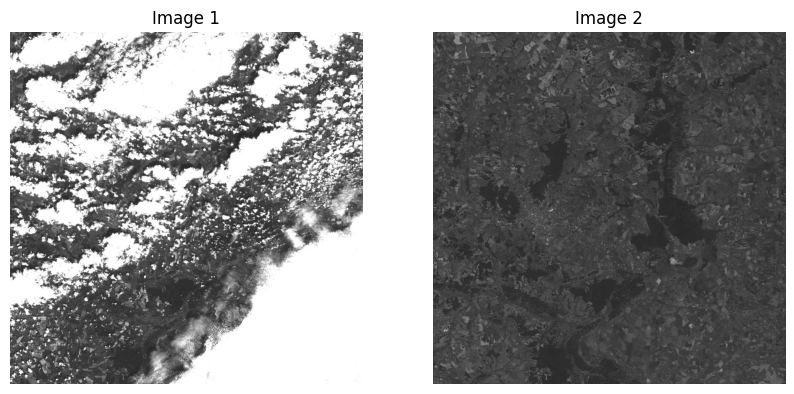

In [27]:
# Debug matched images
img_path_1 = 'smaller_dev_dataset/L1C_T36UYA_A021082_20190706T083605/T36UYA_20190706T083611_TCI.jpg';
img_path_2 = 'smaller_dev_dataset/L1C_T36UYA_A021797_20190825T083616/T36UYA_20190825T083601_TCI.jpg'
load_and_display_images(img_path_1, img_path_2)

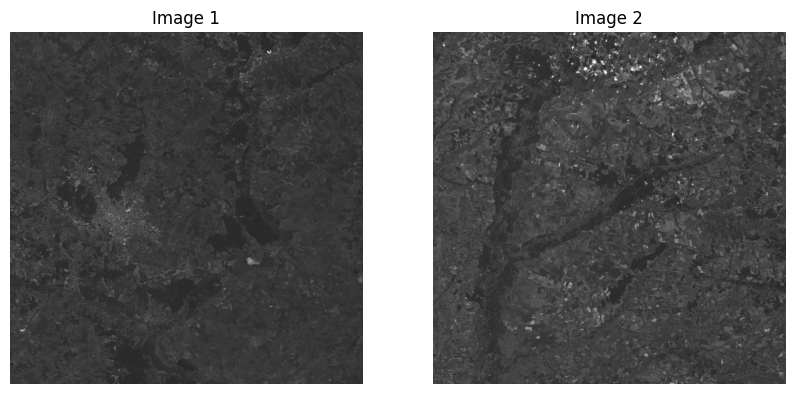

In [28]:
# Wasn't matched:
img_path_1 = 'smaller_dev_dataset/L1C_T36UYA_A020653_20190606T083602/T36UYA_20190606T083601_TCI.jpg';
img_path_2 = 'smaller_dev_dataset/L1C_T36UXA_A016935_20180919T084300/T36UXA_20180919T083621_TCI.jpg'
load_and_display_images(img_path_1, img_path_2)

In [29]:
def draw_matches_with_recomputed_keypoints(img1_path, img2_path):
    # Load images
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    # Detect keypoints and compute descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Match descriptors
    bf = cv2.BFMatcher()
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw first 10 matches
    result = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=2)

    # Display the result
    plt.imshow(result, cmap='gray')
    plt.show()

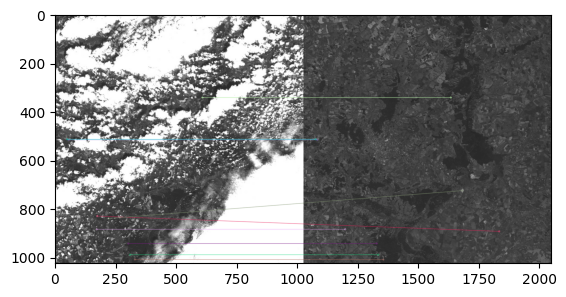

In [30]:
img_path_1 = 'smaller_dev_dataset/L1C_T36UYA_A021082_20190706T083605/T36UYA_20190706T083611_TCI.jpg';
img_path_2 = 'smaller_dev_dataset/L1C_T36UYA_A021797_20190825T083616/T36UYA_20190825T083601_TCI.jpg'
draw_matches_with_recomputed_keypoints(img_path_1, img_path_2)

---